In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

In [2]:
X = ((6*10**6)**3/(6.674*10**(-11)*6*10**(24)))**0.5
MS = 5000
print('seconds per step: ', (2*np.pi*2**1.5)*X/MS)

seconds per step:  2.6104357394519746


## Solving the System of Equations

$\ddot{r} = r \dot{\theta}^2 - \frac{1}{r^2}$

$\ddot{\theta} = -2 \frac{\dot{r}}{r} \dot{\theta}$ 

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

$y_2 = \theta$

$y_3 = \dot{\theta}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 = y_0 y_3^2 - \frac{1}{y_0^2}$

$\dot{y}_2 = y_3$

$\dot{y}_3 = -2 \frac{y_1}{y_0} y_3$ 

### RK4 Algorithm


In [186]:
class OrbitalDynamicsEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, ln_m = 1000.0, dt_s = 1.0, target_r = 2.0, thrust_gs= 1.25, verbose = False, 
                 record_history = True, record_rate = 100):
        super(OrbitalDynamicsEnv, self).__init__()
        self.record_rate = record_rate
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([0, 100.0]), 
                                           high=np.array([100.0, 100.0]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0., -10., 0.0, -10.0]), 
                                                high=np.array([10., 10., 2*np.pi, 10.0]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # Newton's Gravitational Constant in SI units
        G = 6.674*10**(-11) # m^3 kg^-1 s^-2 
        planet_Mass_kg = 5.972*10**(24)
        planet_R_km = 6371.0
        planet_R_m = planet_R_km*10**3
        self.planet_R_ln = planet_R_m/ln_m
        
        # Convert to Natural Problem Units
        # tn_s = (R^2/GM*X m)^1/2 -- where all measures are in SI units
        
        tn_s = (planet_R_m**2/(G*planet_Mass_kg)*ln_m)**0.5
        
        # define the time step in seconds
        self.dts = dt_s
        # define the natural length in meters
        self.ln_m = ln_m
        # convert the time step in seconds to natural time
        self.dt = dt_s/tn_s
        
        if verbose:
            print('Units')
            print('-----')
            print('\ttime: 1 s = ', 1.0/tn_s,' tn')
            print('\tlength: 1 m = ',1/ln_m,' ln')
            print('Simulation parameters')
            print('-----')
            print('\tnatural units time step size: ',self.dt)
        
        # setting the target altitude in natural units
        self.target_r = self.planet_R_ln + target_r
        self.max_r = self.planet_R_ln + 2.0*self.target_r
        
        # solving the oribital angular velocity in natural units
        self.orbit_theta_dot = self.planet_R_ln*self.target_r**(-1.5)
        self.max_theta_dot = 10.0*self.orbit_theta_dot
        
        # solving the maxium allowable natural time to run an episode
        self.max_time = 2*np.pi/self.orbit_theta_dot
        # adding in a buffer to allow it to go a little longer
        self.max_time = 5*self.max_time
        # solving the maximum allowable steps given the max time
        self.max_steps = np.int32(np.ceil(self.max_time/self.dt))
        
        if verbose:
            print('\ttarget theta dot: ', self.orbit_theta_dot, ' 1/tn')
            print('\tmax allowable natural time: ', self.max_time, " tn = ", self.max_time*tn_s," s")
            print('\tmax allowed steps: ', self.max_steps)
            
        
        # max accleration from thrust in natural units (ln/tn^2)
        # 1 g = GM/R_planet^2 --in natural units--> 1 g = (ln^3/tn^2)/(ln^2)
        # 1 g. = 1 ln/tn^2
        self.max_thrust = thrust_gs
        self.max_o_thrust = 1.5
        
        if verbose:
            print('Policy Parameters')
            print('-----')
            max_thrust_SI = self.max_thrust*(self.ln_m)/(tn_s**2)
            # as a reference https://www.nasa.gov/pdf/466711main_AP_ST_ShuttleAscent.pdf
            # says the spaceshuttle never exceeded 3gs or ~ 30 m/s^2
            print('\tDiscrete thrust acceleration: ', self.max_thrust,' ln/tn^2 = ', max_thrust_SI,' m/s^2')
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Orientation Coordinate in global coordinates
        self.orientation_rate = 0.0
        self.orientation_angle = 0.0
        
        # Translational Coordinates
        self.r = self.planet_R_ln
        self.r_dot = 0.0
        self.r_double_dot = 0.0
        
        self.theta = 0.0
        self.theta_dot = 0.0 # can change this if u want to add planetary rotation
        self.theta_double_dot = 0.0
        
        self.elapsed_time = 0.0 # elapsed sim time in natural units
        self.elapsed_time_s = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r*np.cos(self.theta), self.r*np.sin(self.theta), 
                                         self.orientation_angle]])
        
        obs = np.array([self.r, self.r_dot, self.theta, self.theta_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        self.steps += 1
        
        # actions segragation
        thrust = np.clip(action[0], 0.0, self.max_thrust)
        orientation_thrust = np.clip(action[1], -self.max_o_thrust, self.max_o_thrust) 

        # Translating the actions into the planet centric coordinate system
        action_vector = thrust*np.array([np.cos(self.orientation_angle), 
                                         np.sin(self.orientation_angle)])
        
        # Apply the orientation action prior to the state propagator
        self.orientation_angle += self.orientation_rate*self.dt + 0.5*orientation_thrust*self.dt**2
        self.orientation_rate += orientation_thrust*self.dt

        # current r hat vector and theta hat vector
        r_vect = np.array([np.cos(self.theta), np.sin(self.theta)])
        theta_vect = np.array([-np.sin(self.theta), np.cos(self.theta)])
        
        # projection of actions along r and theta 
        action_along_r = np.dot(r_vect, action_vector)
        action_along_theta = np.dot(theta_vect, action_vector)
        
        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt
        self.elapsed_time_s += self.dts

        # integrate
        rd_k1 = self.r_dot
        rdd_k1 = self.r*self.theta_dot**2 - self.planet_R_ln**2/self.r**2 + action_along_r
        thetad_k1 = self.theta_dot
        thetadd_k1 = -2.0*self.r_dot/self.r*self.theta_dot + action_along_theta
        
        rd_k2 = (self.r_dot + rdd_k1*self.dt/2)
        rdd_k2 = (self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k1*self.dt/2)**2 + action_along_r
        thetad_k2 = (self.theta_dot + thetadd_k1*self.dt/2)
        thetadd_k2 = -2.0*(self.r_dot + rdd_k1*self.dt/2)/(self.r + rd_k1*self.dt/2)*(self.theta_dot + thetadd_k1*self.dt/2) + action_along_theta
        
        rd_k3 = (self.r_dot + rdd_k2*self.dt/2)
        rdd_k3 = (self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2)**2 - self.planet_R_ln**2/(self.r + rd_k2*self.dt/2)**2 + action_along_r
        thetad_k3 = (self.theta_dot + thetadd_k2*self.dt/2)
        thetadd_k3 = -2.0*(self.r_dot + rdd_k2*self.dt/2)/(self.r + rd_k2*self.dt/2)*(self.theta_dot + thetadd_k2*self.dt/2) + action_along_theta
        
        rd_k4 = (self.r_dot + rdd_k3*self.dt)
        rdd_k4 = (self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt)**2 - self.planet_R_ln**2/(self.r + rd_k3*self.dt)**2 + action_along_r
        thetad_k4 = (self.theta_dot + thetadd_k3*self.dt)
        thetadd_k4 = -2.0*(self.r_dot + rdd_k3*self.dt)/(self.r + rd_k3*self.dt)*(self.theta_dot + thetadd_k3*self.dt) + action_along_theta
        
        # Update 
        self.r = self.r + self.dt/6*(rd_k1 + 2*rd_k2 + 2*rd_k3 + rd_k4)
        self.r_dot = self.r_dot + self.dt/6*(rdd_k1 + 2*rdd_k2 + 2*rdd_k3 + rdd_k4)

        self.theta = self.theta + self.dt/6*(thetad_k1 + 2*thetad_k2 + 2*thetad_k3 + thetad_k4)
        self.theta_dot = self.theta_dot + self.dt/6*(thetadd_k1 + 2*thetadd_k2 + 2*thetadd_k3 + thetadd_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot,self.theta,self.theta_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory, 
                                        [[self.r*np.cos(self.theta), 
                                          self.r*np.sin(self.theta), 
                                          self.orientation_angle]], 
                                        axis=0)
        
        # GET TO THE TARGET ALT BY USING THE LEAST THRUST
        
        '''
        reward = 0.0
        if (self.r - self.target_r)**2 < (0.01)**2:
            reward += 2.0
        if (self.theta_dot - self.orbit_theta_dot)**2 < (0.01)**2:
            reward += 2.0
        '''
        
        reward = np.min([1000., self.target_r/np.abs(self.r - self.target_r)])
        
        # set if at the terminal state
        done = False
            
        if (self.r < self.planet_R_ln):
            done = True
            #reward -= 2.0
        
        if self.steps > self.max_steps:
            done = True
        
        if (self.r > self.max_r) or (np.abs(self.theta_dot) > self.max_theta_dot):
            done = True
            #reward -= 2.0
        
        reward *= self.dt
            
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1, xlim=None, ylim=None):
        
        fig = plt.figure(figsize=(size,size), dpi=100)
        ax = fig.add_subplot(111)
        ax.set_aspect(1) 
        
        # Planet Surface
        x = np.linspace(-self.planet_R_ln, self.planet_R_ln, 100,endpoint=True)
        plt.plot(x, np.sqrt(self.planet_R_ln**2-x**2), c='k')
        plt.plot(x,-np.sqrt(self.planet_R_ln**2-x**2), c='k')
        
        # Trajectory
        plt.plot(self.trajectory[::sample_traj_rate,0], self.trajectory[::sample_traj_rate,1], c='b')
        
        # orientation vector every Nth
        action_vect_length = 0.05*self.planet_R_ln
        xaxis_orientation = self.trajectory[::sample_traj_rate,2]
        # vector terminal pts
        start_pts = self.trajectory[::sample_traj_rate,[0,1]]
        end_pts = start_pts + action_vect_length*np.dstack((np.cos(xaxis_orientation), np.sin(xaxis_orientation)))[0]
        
        for idx in range(len(start_pts)):
            plt.plot([start_pts[idx,0],end_pts[idx,0]], [start_pts[idx,1],end_pts[idx,1]], c='r')
        
        if xlim != None:
            plt.xlim(xlim[0], xlim[1])
            plt.ylim(ylim[0], ylim[1])
        plt.show();
        
        fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(size,size), dpi=100)
        axs[0].plot(np.sqrt(self.trajectory[::sample_traj_rate,0]**2+self.trajectory[::sample_traj_rate,1]**2), c='b')
        axs[0].set_ylabel('altitude (ln)')
        axs[0].set_xlabel('time (steps)')
        
        axs[1].plot(np.arctan2(self.trajectory[::sample_traj_rate,1],self.trajectory[::sample_traj_rate,0])*180/np.pi, c='b')
        axs[1].set_ylabel('latitude (degrees)')
        axs[1].set_xlabel('time (steps)')
        
        axs[2].plot((self.trajectory[::sample_traj_rate,2]*180/np.pi) % 360, c='b')
        axs[2].set_ylabel('orientation to x-axis (degrees)')
        axs[2].set_xlabel('time (steps)')
        plt.tight_layout()

## Example Policy

In [187]:
env = OrbitalDynamicsEnv(dt_s = 1.0, ln_m = 1000.0, target_r = 70.0, thrust_gs= 2.0, record_history=False)

test_env = OrbitalDynamicsEnv(dt_s = 1.0, ln_m = 1000.0, target_r = 70.0, thrust_gs= 2.0, 
                              record_history=True, 
                              verbose=True, record_rate = 5)

Units
-----
	time: 1 s =  0.09909355192350287  tn
	length: 1 m =  0.001  ln
Simulation parameters
-----
	natural units time step size:  0.09909355192350287
	target theta dot:  0.012324736880691654  1/tn
	max allowable natural time:  2549.0139740926375  tn =  25723.30817307262  s
	max allowed steps:  25724
Policy Parameters
-----
	Discrete thrust acceleration:  2.0  ln/tn^2 =  19.639064065631917  m/s^2


In [165]:
test_env.reset()

test_env.r = test_env.target_r
test_env.theta_dot = test_env.orbit_theta_dot


for i in range(5000):
    ns,r,d,_ = test_env.step([0.0,0.0])
    if d:
        print('done at ',i)
        break
        
test_env.trajectory = test_env.trajectory[1:] 

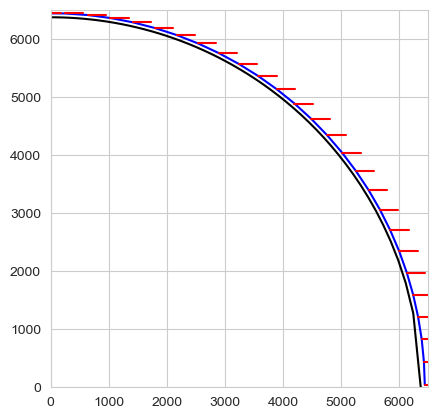

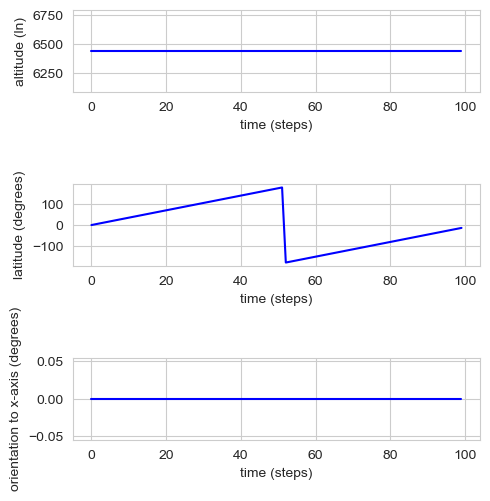

In [149]:
test_env.render(sample_traj_rate=10, xlim=[0, 6500], ylim=[0,6500])

In [166]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    # play count episodes
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)
            mu_v = net(obs_v)[0]
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            state, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

In [167]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [168]:
HIDDEN_SIZE = 128

class ModelA2C(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelA2C, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )
        
        self.thruster = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
        
        self.rotation = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
        
        self.var = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, act_size)
        )
        
        self.value = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        base_out = self.base(x)
        
        thrust =  torch.sigmoid(self.thruster(x))*env.max_thrust
        rotation = torch.tanh(self.rotation(x))*env.max_o_thrust*0.0

        mu = torch.cat([thrust,rotation], dim=1)

        
        return mu, torch.abs(self.var(base_out)), self.value(base_out)

In [169]:
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        actions = np.random.normal(mu, sigma)
        actions[:,1] = 0.0
        return actions, agent_states

In [170]:
def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)[2]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v

In [171]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.weight.data *= 0.001
        m.bias.data.fill_(0.0)

In [188]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)

net.apply(init_weights)

agent = AgentA2C(net, device=device)

### Test Net Is Neutral (near zero means, near zero variances)

In [173]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
net(s_v)

(tensor([[1.0000, -0.0000]], device='cuda:0', grad_fn=<CatBackward>),
 tensor([[1.0729e-03, 3.8516e-05]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[-0.0010]], device='cuda:0', grad_fn=<AddmmBackward>))

In [157]:
agent([s],None) # s needs to be numpy array

(array([[1.00244783, 0.        ]]), None)

### Pretrain so that we have good initial settings (the mentor)

In [158]:
net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)

go_thrust_v = torch.FloatTensor([[env.max_thrust*0.5, 0.0]]).to(device)

# this pumps the variance parameters so we start off with high exploration
for _ in range(1):
    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(s_v)
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v =  0.00001*ent_v.mean()
    mu_loss_v = ((mu_v - go_thrust_v)**2).mean()
    
    loss_v = mu_loss_v + entropy_loss_v
    
    loss_v.backward()
    optimizer.step()

In [159]:
net(s_v) # mean near (max_thrust,0) large variances for exploration

(tensor([[2.8185e-13, 0.0000e+00]], device='cuda:0', grad_fn=<CatBackward>),
 tensor([[2057.8669, 1560.9142]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[213.2456]], device='cuda:0', grad_fn=<AddmmBackward>))

In [189]:
GAMMA = 0.999
REWARD_STEPS = 3
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
ENTROPY_BETA = 1e-4

TEST_ITERS = 5000

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, GAMMA, 
                                                       steps_count=REWARD_STEPS)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

batch = []
best_reward = None

#reward_100 = collections.deque(maxlen=100)
    
for step_idx, exp in enumerate(exp_source):
    rewards_steps = exp_source.pop_rewards_steps()
    if rewards_steps:
        rewards, steps = zip(*rewards_steps)
        #reward_100.append(rewards[0])

    if step_idx % TEST_ITERS == 0:
        ts = time.time()
        rewards, steps = test_net(net, test_env, device=device)
        print("Test done is %.2f sec, reward %.3f, steps %d" %\
              (time.time() - ts, rewards, steps))
        #writer.add_scalar("test_reward", rewards, step_idx)
        #writer.add_scalar("test_steps", steps, step_idx)
        if (best_reward is None) or (best_reward < rewards):
            if best_reward is not None:
                print("Best reward updated: %.8f -> %.8f" % (best_reward, rewards))
            best_reward = rewards

    batch.append(exp)
    if len(batch) < BATCH_SIZE:
        continue

    states_v, actions_v, vals_ref_v = unpack_batch_a2c(batch, net, device=device,
                                                       last_val_gamma=GAMMA**REWARD_STEPS)
    batch.clear()

    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(states_v)
    loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)

    adv_v = vals_ref_v.unsqueeze(dim=-1) - value_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, actions_v)
    loss_policy_v = -log_prob_v.mean()
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v = ENTROPY_BETA * ent_v.mean()

    loss_v = loss_policy_v + entropy_loss_v + loss_value_v
    loss_v.backward()
    optimizer.step()

Test done is 0.01 sec, reward 9.118, steps 1
Test done is 83.61 sec, reward 61867.579, steps 6408
Best reward updated: 9.11802204 -> 61867.57926167
Test done is 80.12 sec, reward 60812.312, steps 6302
Test done is 76.34 sec, reward 57864.990, steps 6014
Test done is 74.89 sec, reward 56828.339, steps 5917
Test done is 76.58 sec, reward 57785.047, steps 6007
Test done is 75.44 sec, reward 57161.356, steps 5948
Test done is 75.51 sec, reward 57227.548, steps 5954
Test done is 78.57 sec, reward 57041.069, steps 5936


KeyboardInterrupt: 

In [190]:
states_v

tensor([[6.7479e+03, 6.7710e+00, 0.0000e+00, 0.0000e+00],
        [6.7486e+03, 6.6827e+00, 0.0000e+00, 0.0000e+00],
        [6.7492e+03, 6.5944e+00, 0.0000e+00, 0.0000e+00],
        [6.7499e+03, 6.7043e+00, 0.0000e+00, 0.0000e+00],
        [6.7506e+03, 6.8142e+00, 0.0000e+00, 0.0000e+00],
        [6.7512e+03, 6.7396e+00, 0.0000e+00, 0.0000e+00],
        [6.7519e+03, 6.6514e+00, 0.0000e+00, 0.0000e+00],
        [6.7526e+03, 6.7614e+00, 0.0000e+00, 0.0000e+00],
        [6.7532e+03, 6.8713e+00, 0.0000e+00, 0.0000e+00],
        [6.7539e+03, 6.7832e+00, 0.0000e+00, 0.0000e+00],
        [6.7546e+03, 6.7578e+00, 0.0000e+00, 0.0000e+00],
        [6.7553e+03, 6.8678e+00, 0.0000e+00, 0.0000e+00],
        [6.7559e+03, 6.7797e+00, 0.0000e+00, 0.0000e+00],
        [6.7566e+03, 6.8898e+00, 0.0000e+00, 0.0000e+00],
        [6.7573e+03, 6.9859e+00, 0.0000e+00, 0.0000e+00],
        [6.7580e+03, 6.8978e+00, 0.0000e+00, 0.0000e+00],
        [6.7587e+03, 6.8098e+00, 0.0000e+00, 0.0000e+00],
        [6.759

In [191]:
actions_v

tensor([[-2.4334,  0.0000],
        [-3.6997,  0.0000],
        [ 4.6939,  0.0000],
        [ 2.2993,  0.0000],
        [ 0.1383,  0.0000],
        [-4.1542,  0.0000],
        [ 4.7305,  0.0000],
        [ 7.0967,  0.0000],
        [-0.2832,  0.0000],
        [ 0.6338,  0.0000],
        [ 9.6950,  0.0000],
        [-6.3336,  0.0000],
        [ 5.7569,  0.0000],
        [ 1.8591,  0.0000],
        [-2.0985,  0.0000],
        [-2.4789,  0.0000],
        [ 1.0412,  0.0000],
        [ 0.7235,  0.0000],
        [-2.1744,  0.0000],
        [ 2.3840,  0.0000],
        [ 4.2185,  0.0000],
        [ 1.0864,  0.0000],
        [-0.2984,  0.0000],
        [-0.2753,  0.0000],
        [-0.3424,  0.0000],
        [-5.9550,  0.0000],
        [ 2.7827,  0.0000],
        [ 3.7522,  0.0000],
        [-1.9751,  0.0000],
        [-0.8765,  0.0000],
        [ 6.6587,  0.0000],
        [ 5.4455,  0.0000],
        [ 2.2987,  0.0000],
        [ 0.4843,  0.0000],
        [-3.4311,  0.0000],
        [-4.1024,  0

In [192]:
vals_ref_v

tensor([328.9594, 328.9802, 328.9975, 329.0143, 329.0349, 329.0560, 329.0735,
        329.0918, 329.1130, 329.1306, 329.1519, 329.1735, 329.1916, 329.2094,
        329.2290, 329.2481, 329.2659, 329.2874, 329.3094, 329.3301, 329.3485,
        329.3666, 329.3844, 329.4021, 329.4236, 329.4457, 329.4641, 329.4822,
        329.5041, 329.5265, 329.5494, 329.5695, 329.5884, 329.6071, 329.6281,
        329.6469, 329.6679, 329.6866, 329.7090, 329.7279, 329.7465, 329.7647,
        329.7827, 329.8005, 329.8222, 329.8445, 329.8672, 329.8902, 329.9137,
        329.9333, 329.9527, 329.9758, 329.9954, 330.0159, 330.0392, 330.0589,
        330.0824, 330.1022, 330.1257, 330.1498, 330.1743, 330.1993, 330.2206,
        330.2455], device='cuda:0')

In [193]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
net(s_v)

(tensor([[1.0006, 0.0000]], device='cuda:0', grad_fn=<CatBackward>),
 tensor([[ 9.2851, 10.4128]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[306.6200]], device='cuda:0', grad_fn=<AddmmBackward>))

In [194]:
test_net(net, test_env, count=1, device=device)
#test_net(up_net, test_env, count=1)

(57028.32501212979, 5935.0)

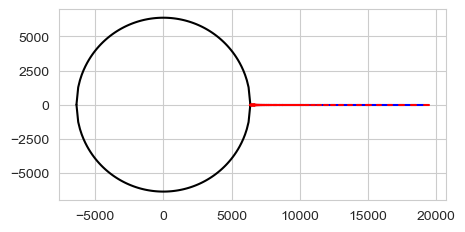

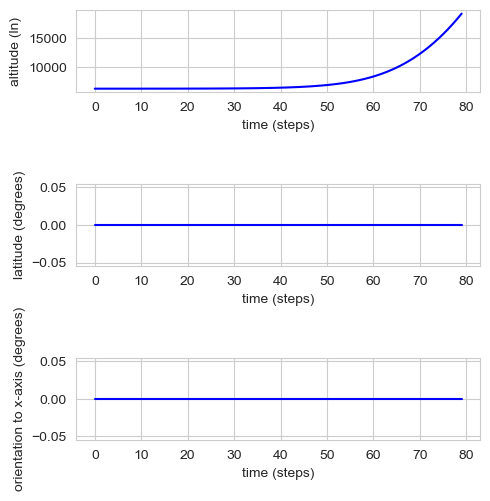

In [195]:
sns.set_style('whitegrid')
test_env.render(sample_traj_rate=15)

## Vanilla Policy Gradient Method

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: ',device)

HIDDEN_SIZE = 128

class PGN(nn.Module):
    def __init__(self, in_size):
        super(PGN,self).__init__()
        
        self.actions_mu = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
    
        self.actions_var = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
        
        self.values =  nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def __call__(self, x):
        return self.actions_mu(x), self.actions_var(x), self.values(x)
    
policy_net = PGN(4).to(device)

policy_net

using device:  cpu


PGN(
  (actions_mu): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (actions_var): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (values): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [149]:
ridx = np.random.choice(range(len(traj_s)),size = 1000)
states_v = torch.FloatTensor(np.array(traj_s)[ridx])
actions_v = torch.LongTensor(np.array(traj_a)[ridx])
#actions_v = torch.eye(4)[traj_a]

In [178]:
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

In [152]:
for e in range(5000):
    optimizer.zero_grad()
    mu_v, var_v, _ = policy_net(states_v)
    
    loss_v = ((mu_v - actions_v)**2).mean()
    loss_v.backward()
    optimizer.step()
    
    if e % 100 == 0:
        print(loss_v.item())

0.611042857170105
0.07870986312627792
0.04247419536113739
0.029623961076140404
0.0246701892465353
0.022615090012550354
0.021483683958649635
0.020682865753769875
0.01997537910938263
0.019331539049744606
0.01875515654683113
0.018252111971378326
0.017818685621023178
0.01744617521762848
0.01712161675095558
0.016824597492814064
0.01656264252960682
0.01633056439459324
0.016125833615660667
0.015943657606840134
0.015776731073856354
0.015621383674442768
0.015472836792469025
0.015327652916312218
0.01518517266958952
0.015045098960399628
0.01490660198032856
0.01477011013776064
0.014637439511716366
0.014506872743368149
0.014379916712641716
0.014262971468269825
0.014149095863103867
0.014043898321688175
0.013938740827143192
0.01384030096232891
0.013742691837251186
0.013647002167999744
0.013478003442287445
0.013384887017309666
0.013283448293805122
0.013193108141422272
0.013111486099660397
0.01303156465291977
0.012958995997905731
0.012887602671980858
0.012806102633476257
0.012738815508782864
0.01267056

In [162]:
state = env.reset()
episode_R = 0.0

while True:
    state_v = torch.FloatTensor([state])
    mu_v, var_v, _ = policy_net(state_v)
    mu = mu_v.data.cpu().numpy()[0]
    
    state, reward, is_done, _ = env.step(mu)
    episode_R += reward
    if is_done:
        break

In [163]:
episode_R

-631.6050344747143

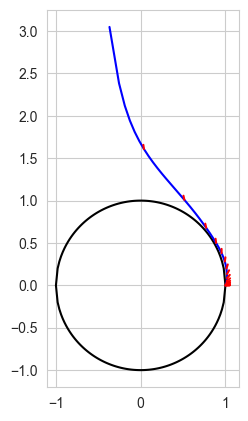

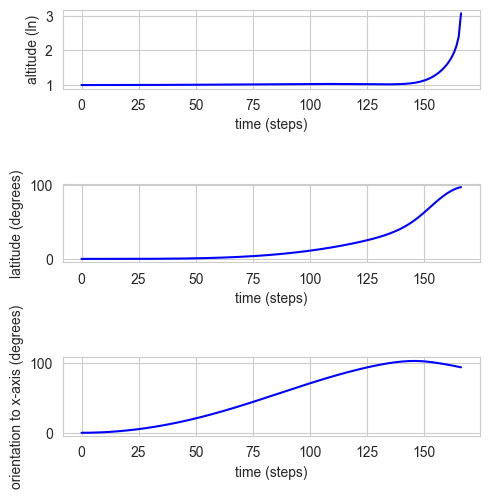

In [164]:
sns.set_style('whitegrid')
env.render()

In [171]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

tensor([[-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209]], grad_fn=<AddBackward0>)


RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

-1572.8280186113989 4055.6625553967274


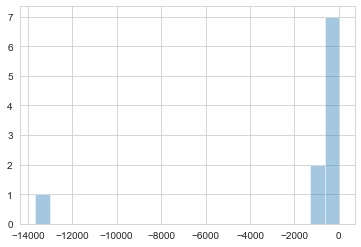

In [174]:
print(np.mean(total_rewards), np.std(total_rewards))
sns.distplot(total_rewards,kde=False);

Episode Reward:  -1105.2090478697733


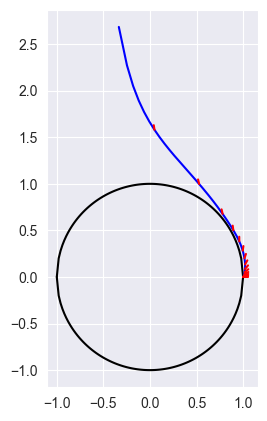

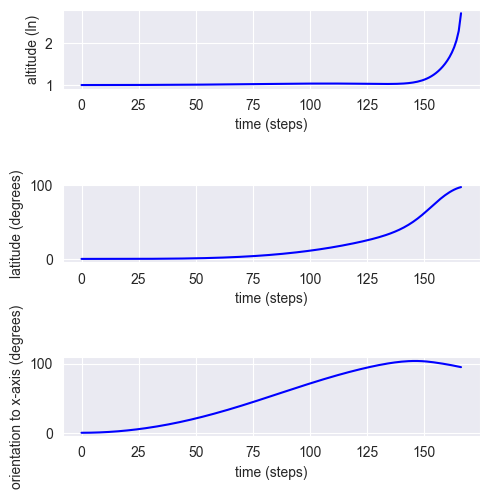

In [176]:
s = env.reset()

episode_reward = 0.0

program_cmd_history = []

done = False
while not done:
    s_v = torch.FloatTensor(s).unsqueeze(0).to(device)
    mu_v, var_v, _ = policy_net(s_v)
    mu = mu_v.data.cpu().numpy()
    var = var_v.data.cpu().numpy()
    a = [np.random.normal(loc=mu[0,0],scale=np.abs(var[0,0])),
         np.random.normal(loc=mu[0,1],scale=np.abs(var[0,1]))]

    program_cmd_history.append(a)    
    s, r, done,_ = env.step(a)
    episode_reward +=r

print('Episode Reward: ', episode_reward)
sns.set_style('darkgrid')
env.render()

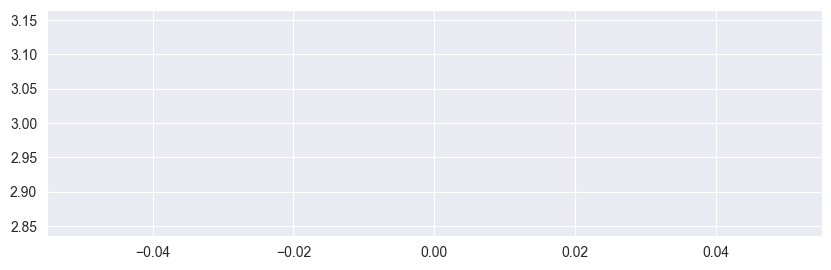

In [95]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(program_cmd_history);